In [1]:
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from typing import TypedDict, Literal
from dotenv import load_dotenv
from pydantic import BaseModel, Field

In [2]:
load_dotenv()

True

In [3]:
model = ChatGoogleGenerativeAI(model="gemini-2.5-flash")

E0000 00:00:1761144051.824279  483079 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


In [4]:
class SentimentSchema(BaseModel):
    sentiment: Literal["positive", "negative"] = Field(description="The sentiment of the review")

class DiagnosisSchema(BaseModel):
    issue_type: Literal["UX", "Performance", "Bug", "Support", "Other"] = Field(description="The type of issue mentioned in the review")
    tone: Literal["Angry", "Frustrated", "Disappointed", "Calm"] = Field(description="The emotional tone expressed by the user.")
    urgency: Literal["Low", "Medium", "High"] = Field(description="The urgency level of the user's issue.")

In [5]:
structured_model = model.with_structured_output(SentimentSchema)
structured_model2 = model.with_structured_output(DiagnosisSchema)

In [6]:
prompt = "What is the sentiment of the following review: 'The product was great and met all my expectations!'"
structured_model.invoke(prompt).sentiment

'positive'

In [7]:
class ReviewState(TypedDict):
    review: str
    sentiment: Literal["positive", "negative"]
    diagnosis: str
    response: str

In [11]:
def find_sentiment(state: ReviewState):
    prompt = f"What is the sentiment of the following review: \n '{state['review']}'"
    return {"sentiment": structured_model.invoke(prompt).sentiment}

def check_sentiment(state: ReviewState) -> Literal['positive_response', 'run_diagnosis']:
    if state['sentiment'] == 'positive':
        return 'positive_response'
    else:
        return 'run_diagnosis'
    
def positive_response(state: ReviewState):
    prompt = f"""Write a warm, thank you message in response to this review:
    \n '{state['review']}' \n
    Also, kindly ask the user to leave feedback on our website."""
    response = model.invoke(prompt).content
    return {"response": response}

def run_diagnosis(state: ReviewState):
    prompt = f"""Diagnose this negative review: \n '{state['review']}' \n
    Return the issue type, emotional tone, and urgency level."""
    response = structured_model2.invoke(prompt)
    return {"diagnosis": response.model_dump()}

def negative_response(state: ReviewState):
    diagnosis = state['diagnosis']
    prompt = f"""You are a support assistant.
    The user had a '{diagnosis['issue_type']}' issue with a '{diagnosis['tone']}' tone and a '{diagnosis['urgency']}' urgency level.
    Write an empathetic, helpful resolution message."""
    response = model.invoke(prompt).content
    return {"response": response}


In [12]:
# create the graph
graph = StateGraph(ReviewState)

graph.add_node('find_sentiment', find_sentiment)
graph.add_node('positive_response', positive_response)
graph.add_node('negative_response', negative_response)
graph.add_node('run_diagnosis', run_diagnosis)

graph.add_edge(START, 'find_sentiment')

graph.add_conditional_edges('find_sentiment', check_sentiment)
graph.add_edge('positive_response', END)
graph.add_edge('run_diagnosis', 'negative_response')
graph.add_edge('negative_response', END)

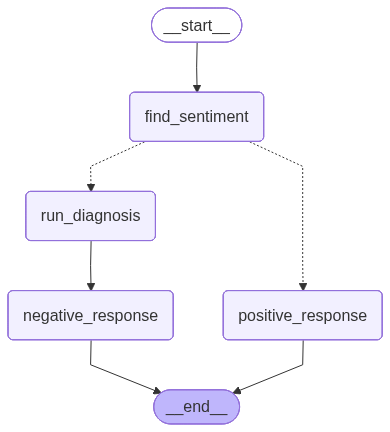

In [13]:
workflow = graph.compile()
workflow

In [17]:
initial_state = {'review': "I have been using this app for about a month now, and I must say the user interface is incredibly clean and intuitive. Everything is exactly where you would expect it to be. It's rare to find something that just works without needing a tutorial. Great job to the design team."}
result = workflow.invoke(initial_state)
print(result['response'])

That's a fantastic review! Here's a warm thank you message:

---

Dear [User's Name, if you have it, otherwise "Dear Valued User" or simply omit],

Thank you so much for taking the time to share your wonderful feedback! We're absolutely thrilled to hear you've been enjoying the app for the past month.

Your comments about the user interface being "incredibly clean and intuitive" and how "everything is exactly where you would expect it to be" truly hit home for us. We especially appreciate you noticing that it "just works without needing a tutorial" – that's exactly what our design team strives for! We'll be sure to pass your kind words directly to them; they'll be absolutely delighted.

Your detailed feedback is incredibly valuable and helps us continue to improve. If you ever have more thoughts or suggestions, we'd be incredibly grateful if you could share them on our website. You can find our feedback section here: [Link to your website feedback page]

Thanks again for your support a

In [18]:
initial_state2 = {'review': "I'm really disappointed with this app. It crashes all the time and the performance is terrible. I've tried reaching out to support but haven't received any help. This has been a frustrating experience overall."}
result2 = workflow.invoke(initial_state2)
print(result2['response'])

Subject: Good News! Your Bug Issue Has Been Resolved - [Your Issue ID/Reference Number]

Hi [User Name],

I'm so sorry to hear you've been experiencing this bug, and I completely understand how frustrating it must have been, especially with its high urgency. Thank you for bringing it to our attention so promptly.

I'm happy to report that our team has investigated the issue thoroughly and we've successfully implemented a fix. It appears there was a [brief, non-technical description of cause if known, e.g., 'temporary data synchronization error' or 'small configuration glitch'] on our end, which we've now corrected.

To ensure everything is running smoothly on your end, please try clearing your browser cache and cookies, then logging back in. Alternatively, if you're using our app, a quick restart should do the trick.

We've monitored the fix and confirmed it's working as expected. Please test it out and let us know if you encounter any further issues or if anything doesn't seem right. 